In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from data import get_data, meta
from plots import *

In [2]:
sns.set()

In [5]:
fig_folder = 'plots/waves'
data = get_data()

vs_seco_outliers = ['GB02-02', 'GB02-05']

In [6]:
display(multi_table([
    data.groupby("litologia")['vp_seco'].describe()[['count', 'min', 'max', 'mean', 'std']].round(2),
    data.drop(vs_seco_outliers).groupby("litologia")['vs_seco'].describe()[['count', 'min', 'max', 'mean', 'std']].round(2)
]))

display(multi_table([
    data.groupby("litologia")['vp_sat'].describe()[['count', 'min', 'max', 'mean', 'std']].round(2),
    data.drop(vs_seco_outliers).groupby("litologia")['vs_sat'].describe()[['count', 'min', 'max', 'mean', 'std']].round(2)
]))

,count,min,max,mean,std
litologia,,,,,
Basalto Maciço,25.0,4.77,6.01,5.54,0.29
Basalto Vesiculado,4.0,3.06,5.19,4.03,0.93
Basalto Brechado,2.0,3.83,5.02,4.43,0.84
Basalto Hidrotermal,1.0,5.54,5.54,5.54,NaN
Peperito,4.0,4.09,5.13,4.53,0.46
Riolito,1.0,5.21,5.21,5.21,NaN
Arenito,1.0,2.46,2.46,2.46,NaN
,count,min,max,mean,std
litologia,,,,,


,count,min,max,mean,std
litologia,,,,,
Basalto Maciço,25.0,4.79,6.05,5.59,0.30
Basalto Vesiculado,4.0,3.24,5.39,4.18,0.97
Basalto Brechado,2.0,3.81,5.11,4.46,0.92
Basalto Hidrotermal,1.0,5.66,5.66,5.66,NaN
Peperito,4.0,4.18,5.13,4.55,0.43
Riolito,1.0,5.33,5.33,5.33,NaN
Arenito,1.0,2.48,2.48,2.48,NaN
,count,min,max,mean,std
litologia,,,,,


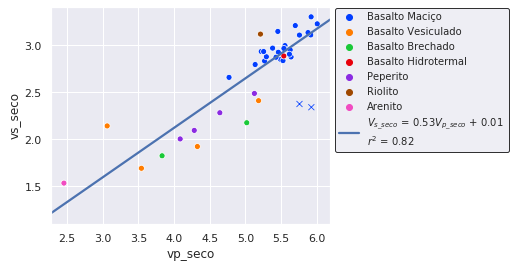

In [7]:
figure,  ax = plt.subplots(1, 1, figsize=(5, 4))

data_2 = data.drop(vs_seco_outliers)

x, y = 'vp_seco', 'vs_seco'
result = ols(formula='%s ~ %s' % (y, x), data=data_2).fit()
label = '$%s$ = %.2f$%s$ + %.2f \n$r^2$ = %.2f' % (meta[y]['symbol'], result.params[1], meta[x]['symbol'], result.params[0], result.rsquared)

sns.scatterplot(x=x, y=y, hue='litologia', data=data.loc[vs_seco_outliers], ax=ax, palette='bright', marker='x')
sns.scatterplot(x=x, y=y, hue='litologia', data=data_2, ax=ax, palette='bright')
sns.regplot(x=x, y=y, data=data_2, scatter=False, ci=False, ax=ax, label=label)


handles, labels = ax.get_legend_handles_labels()
handles, labels = [*handles[10:], handles[0]], [*labels[10:], labels[0]]
ax.legend(handles=handles, labels=labels, prop={'size': 10}, frameon=True, edgecolor='black', bbox_to_anchor=(1, 1.02), loc=2)

plt.savefig('%s/%s_x_%s.png' % (fig_folder, x, y), bbox_inches='tight', dpi=140)
plt.show()

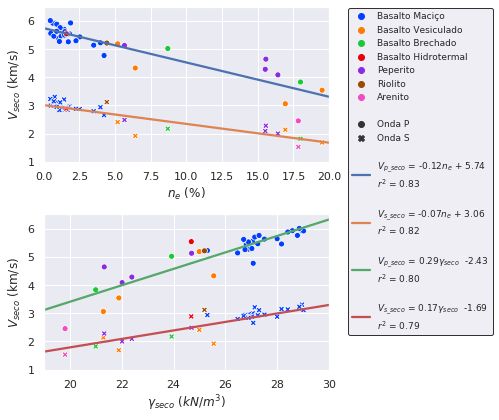

In [8]:
vp_data = (
    data[['p_esp_seco', 'porosidade_efetiva', 'litologia']]
    .assign(v_seco=data['vp_seco'])
    .assign(onda='Onda P')
)

vs_data = (
    data[['p_esp_seco', 'porosidade_efetiva', 'litologia']]
    .drop(vs_seco_outliers)
    .assign(v_seco=data['vs_seco'])
    .assign(onda='Onda S')
)


v_data = pd.concat([vp_data, vs_data])

xs = ['porosidade_efetiva', 'p_esp_seco']
ys = ['vp_seco', 'vs_seco']

figure,  axes = plt.subplots(2, 1, figsize=(5, 6))

for i, x in enumerate(xs):
    ax = axes[i]
    
    sns.scatterplot(x=x, y='v_seco', hue='litologia', style='onda', data=v_data, ax=ax, palette='bright')
    
    for y in ys:
        data_2 = data.drop(vs_seco_outliers) if y == 'vs_seco' else data
        
        result = ols(formula='%s ~ %s' % (y, x), data=data_2).fit()
        label = '$%s$ = %.2f$%s$ %s %.2f \n$r^2$ = %.2f' % (meta[y]['symbol'], result.params[1], meta[x]['symbol'], '+' if result.params[0] > 0 else '', result.params[0], result.rsquared)
        sns.regplot(x=x, y=y, data=data, scatter=False, ci=False, label=label, ax=ax)


    format_ax(x, y, ax, fontsize=12)
    ax.set_ylabel('$V_{seco}$ (km/s)')
    ax.set_ylim([1, 6.5])
    ax.get_legend().remove()

        
plt.tight_layout()

handles1, labels1 = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[1].get_legend_handles_labels()

handles = [*handles1[3:], *handles1[0:2], *handles2[0:2]]
labels = [*labels1[3:], *labels1[0:2], *labels2[0:2]]

labels[7] = ''

for i in [10, 12, 14, 16]:
    handles.insert(i, handles1[2])
    labels.insert(i, '')

axes[0].legend(handles=handles, labels=labels, prop={'size': 9}, frameon=True, edgecolor='black', bbox_to_anchor=(1.05, 1.02), loc=2)

plt.savefig('%s/v_seco_x_props_fisicas.png' % (fig_folder), bbox_inches='tight', dpi=140)
plt.show()

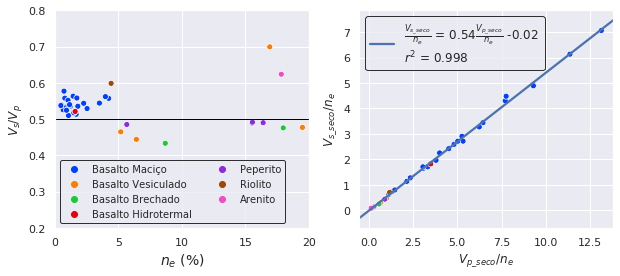

In [9]:
figure,  axes = plt.subplots(1, 2, figsize=(10, 4))


ax = axes[0]

data_2 = data.drop(vs_seco_outliers)
data_2['vs_vp'] = data_2['vs_seco'] / data_2['vp_seco']

x, y = 'porosidade_efetiva', 'vs_vp'
sns.scatterplot(x=x, y=y, hue='litologia', data=data_2, ax=ax, palette='bright')

format_ax(x, None, ax)
ax.set_ylim([0.2, 0.80])
ax.set_ylabel('$V_s/V_p$')
ax.axhline(0.5, c='black', lw=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], prop={'size': 10}, frameon=True, edgecolor='black', ncol=2, loc=3)

ax = axes[1]
data_2['vs_ne'] = data_2['vs_seco'] / data_2['porosidade_efetiva']
data_2['vp_ne'] = data_2['vp_seco'] / data_2['porosidade_efetiva']

x, y = 'vp_ne', 'vs_ne'
sns.scatterplot(x=x, y=y, hue='litologia', data=data_2, ax=ax, palette='bright')

result = ols(formula='%s ~ %s' % (y, x), data=data_2).fit()
label = '$%s$ = %.2f$%s$ %.2f \n$r^2$ = %.3f' % (
    '\\frac{%s}{%s}' % (meta['vs_seco']['symbol'], meta['porosidade_efetiva']['symbol']),
    result.params[1], 
    '\\frac{%s}{%s}' % (meta['vp_seco']['symbol'], meta['porosidade_efetiva']['symbol']),
    result.params[0], 
    result.rsquared
)
sns.regplot(x=x, y=y, data=data_2, scatter=False, ci=False, label=label, ax=ax)
ax.set_xlabel( '$%s/%s$' % (meta['vp_seco']['symbol'], meta['porosidade_efetiva']['symbol']))
ax.set_ylabel( '$%s/%s$' % (meta['vs_seco']['symbol'], meta['porosidade_efetiva']['symbol']))
ax.get_legend().remove()

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[handles[0]], labels=[labels[0]], prop={'size': 12}, frameon=True, edgecolor='black', loc=2)

plt.savefig('%s/%s_x_%s.png' % (fig_folder, x, y), bbox_inches='tight', dpi=140)
plt.show()

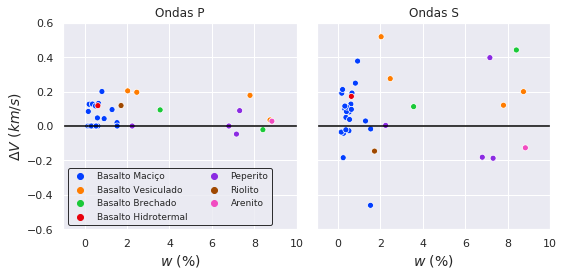

In [10]:
sat_data = data.drop(vs_seco_outliers)

sat_data['delta_vp'] = sat_data['vp_sat'] - sat_data['vp_seco']
sat_data['delta_vs'] = sat_data['vs_sat'] - sat_data['vs_seco']

figure,  axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

x = 'teor_umidade'

for i, y in enumerate(['delta_vp', 'delta_vs']):
    ax = axes[i]
    sns.scatterplot(x=x, y=y, hue='litologia', data=sat_data, ax=ax, palette='bright')
    ax.axhline(c='black')
    ax.set_ylim([-0.6, 0.6])
    ax.set_xlim([-1, 10])
    ax.set_xlabel('$%s$ ($%s$)' % (meta[x]['symbol'], meta[x]['unit']), fontsize=14)
   
    ax.get_legend().remove()

axes[0].set_ylabel('$\Delta V$ ($%s$)' % meta['vp_seco']['unit'], fontsize=14)
axes[0].set_title('Ondas P')
axes[1].set_title('Ondas S')

plt.tight_layout()

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles=handles[1:], labels=labels[1:], prop={'size': 9}, frameon=True, edgecolor='black', ncol=2, loc='lower left')

plt.savefig('%s/saturacao.png' % (fig_folder), bbox_inches='tight', dpi=200)
plt.show()